In [1]:
!pip install torch-summary
!pip install torchmetrics
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
  Using cached torch_summary-1.4.5-py3-none-any.whl.metadata (18 kB)
Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached torchmetrics-1.5.1-py3-none-any.whl.metadata (20 kB)
  Using cached lightning_utilities-0.11.8-py3-none-any.whl.metadata (5.2 kB)
Using cached torchmetrics-1.5.1-py3-none-any.whl (890 kB)
Using cached lightning_utilities-0.11.8-py3-none-any.whl (26 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics


plt.style.use('seaborn-v0_8-darkgrid')


np.__version__


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

# Loading the data

In [3]:
import pandas as pd
import os
from tqdm import tqdm  # Using standard tqdm for compatibility

# Dataset path
PATH = 'C:/Users/gudin/Downloads/eye disesases classification/dataset'

# Creating label mappings
label2id = {label: i for i, label in enumerate(os.listdir(PATH))}
id2label = {value: key for key, value in label2id.items()}

# Collecting file paths and labels
filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])

# Creating DataFrame
df = pd.DataFrame({"filename": filenames, "outcome": outcome})

# Shuffling the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()


100%|██████████| 4/4 [00:00<00:00, 129.71it/s]


,filename,outcome
0,C:/Users/gudin/Downloads/eye disesases classif...,0
1,C:/Users/gudin/Downloads/eye disesases classif...,3
2,C:/Users/gudin/Downloads/eye disesases classif...,3
3,C:/Users/gudin/Downloads/eye disesases classif...,1
4,C:/Users/gudin/Downloads/eye disesases classif...,0


## Plotting the class distribution

We can observe that the distribution is fairly uniform and each class has approximately 1000 images.

C:\Users\gudin\AppData\Local\Temp\ipykernel_92616\1351460292.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outcome', data=df, palette='Blues_d')


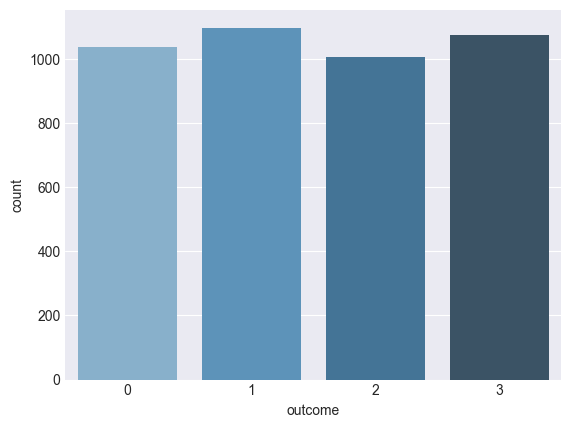

In [4]:
import seaborn as sns  # Make sure Seaborn is imported as sns

# Plotting the count of each class in the 'outcome' column
sns.countplot(x='outcome', data=df, palette='Blues_d')
plt.show()  # Display the plot


## Plotting the sample images

It was found that all the image pixels are not between [0-255]. Hence, simply normalizing or dividing the image with 255 lead to problems. Hence, each image was normalized using the Min-Max Scaling method to bring the values in the range [0, 1].

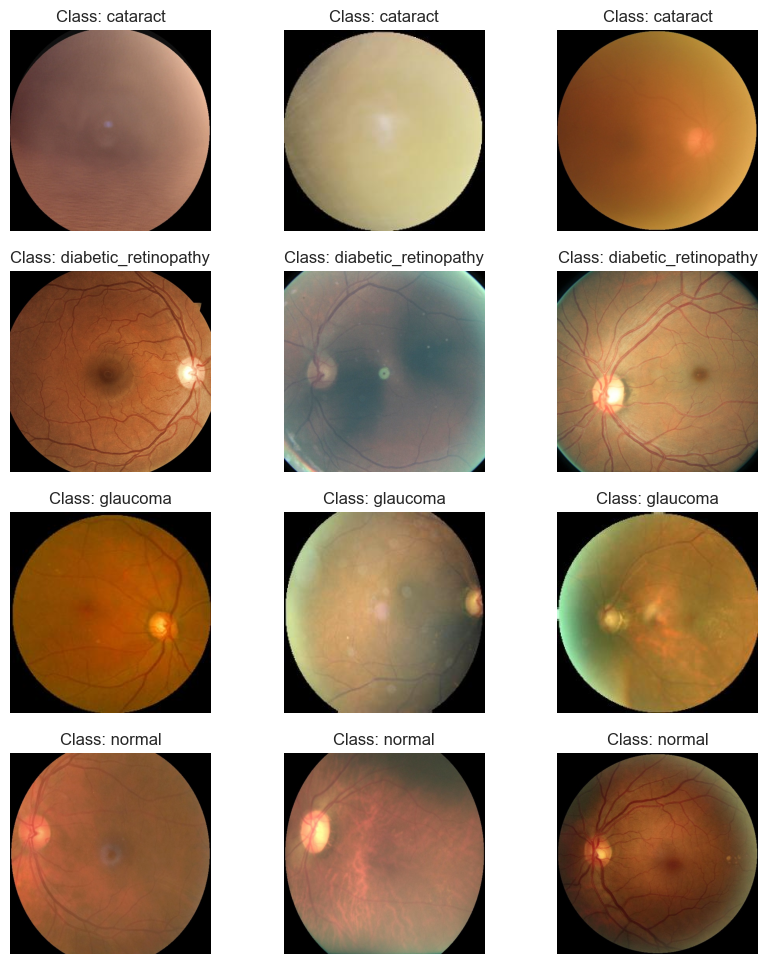

In [5]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1
        
plt.show()

# Building the dataset

1. The dataset was building using `torch.utils.data.Dataset` for efficinet loading of data.
2. For data augmentation, only Random Horizontal and Vertical flip was used. Adding augmentaitons in colors, brightness etc made training difficult, since then 

In [6]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]
        
        img = (img - img.min())/img.max()
        
        if self.transform:
            img = self.transform(img)
            
        return img.to(torch.float32), label

1. 85% of the dataset was used for training while the remaining for validation/testing.
2. Batch Size of 128 was chosen.

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

In [8]:
NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [9]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


In [ ]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
            
        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
        
        
    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])
        
        
    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x
            


class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device
        
        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)
        
        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, acc
    
    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)
            
        return loss, acc
    
    def step_fxn(self, loader, step):
        loss, acc = 0, 0
        
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()
            
        return loss/len(loader), acc/len(loader)
    
    def train(self, epochs):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            
            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)
            
            
            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))
    

In [11]:
trainer = Trainer(train_loader, val_loader, device)

C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Summary of the model

In [12]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

## Training the model

In [13]:
trainer.train(epochs = 3)

 33%|███▎      | 1/3 [04:09<08:19, 249.65s/it]

[Epoch: 1] Train: [loss: 0.732 acc: 0.718] Val: [loss: 0.533 acc:0.818]


 67%|██████▋   | 2/3 [07:29<03:40, 220.40s/it]

[Epoch: 2] Train: [loss: 0.366 acc: 0.860] Val: [loss: 0.370 acc:0.858]


100%|██████████| 3/3 [10:59<00:00, 219.99s/it]

[Epoch: 3] Train: [loss: 0.281 acc: 0.896] Val: [loss: 0.299 acc:0.876]


# Plotting Model Results

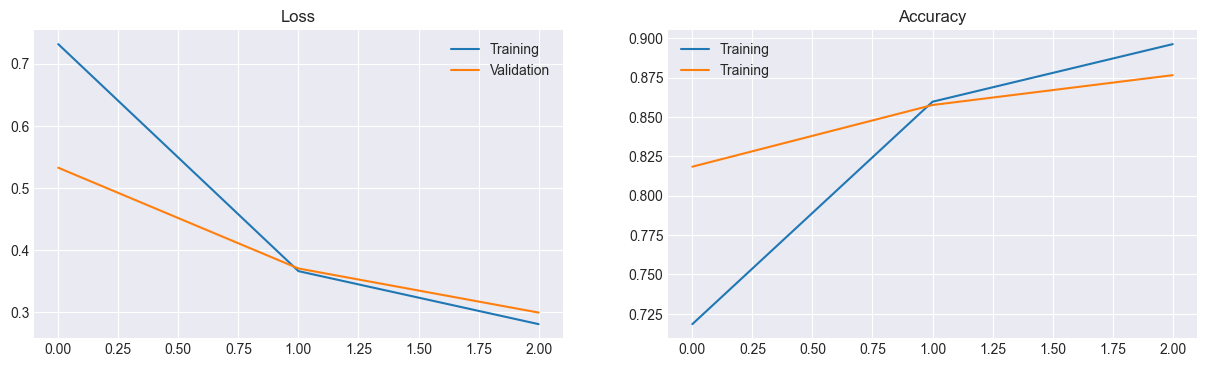

In [14]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()



# Model Predictions

In [15]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)
        
len(preds), len(true)

100%|██████████| 5/5 [00:30<00:00,  6.12s/it]


(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

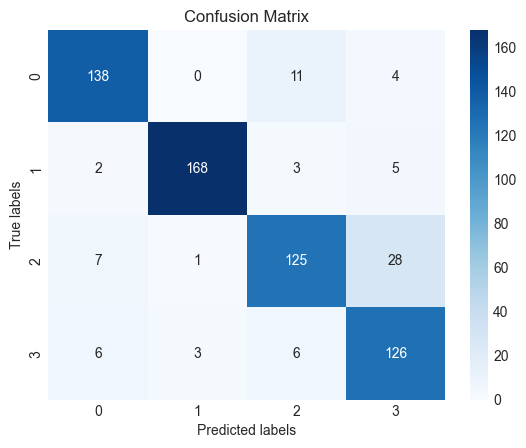

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sea
cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [18]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.90      0.90      0.90       153
diabetic_retinopathy       0.98      0.94      0.96       178
            glaucoma       0.86      0.78      0.82       161
              normal       0.77      0.89      0.83       141

            accuracy                           0.88       633
           macro avg       0.88      0.88      0.88       633
        weighted avg       0.88      0.88      0.88       633



In [20]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the transformations for your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the input size expected by the model
    transforms.ToTensor()
])

# Load dataset (assuming images are organized in class folders)
data_dir = 'C:/Users/gudin/Downloads/eye disesases classification'  # Replace with the path to your image directory
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [34]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tqdm
from sklearn.metrics import classification_report
# Step 1: Load the Pretrained Model and Set Up Feature Extraction
model = models.resnet50(pretrained=True)  # Use ResNet-50 model for feature extraction
model = nn.Sequential(*list(model.children())[:-1])  # Remove the final layer
model.eval()  # Set the model to evaluation mode

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Step 2: Set Up Dataset and DataLoader
data_dir = 'C:/Users/gudin/Downloads/eye disesases classification/dataset'  # Replace with the actual path to your dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input size
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Step 3: Extract Features
feature_list = []
label_list = []

with torch.no_grad():  # Disable gradient calculations for efficiency
    for images, labels in tqdm.tqdm(data_loader):
        features = model(images)
        features = features.view(features.size(0), -1)  # Flatten features to a 2D array
        feature_list.append(features.cpu().numpy())
        label_list.append(labels.cpu().numpy())

# Convert lists to arrays
features = np.concatenate(feature_list, axis=0)
labels = np.concatenate(label_list, axis=0)

# Step 4: Train an SVM Classifier on the Extracted Features
# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Train the SVM model
svm_model = SVC(kernel='linear')  # You can try other kernels like 'rbf'
svm_model.fit(X_train, y_train)

# Step 5: Evaluate the SVM Model
y_pred_svm = svm_model.predict(X_test)
print("SVM Model Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=dataset.classes))


C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 132/132 [04:59<00:00,  2.27s/it]


SVM Model Classification Report:
                      precision    recall  f1-score   support

            cataract       0.90      0.88      0.89       208
diabetic_retinopathy       0.99      0.99      0.99       220
            glaucoma       0.78      0.80      0.79       201
              normal       0.83      0.83      0.83       215

            accuracy                           0.88       844
           macro avg       0.87      0.87      0.87       844
        weighted avg       0.88      0.88      0.88       844



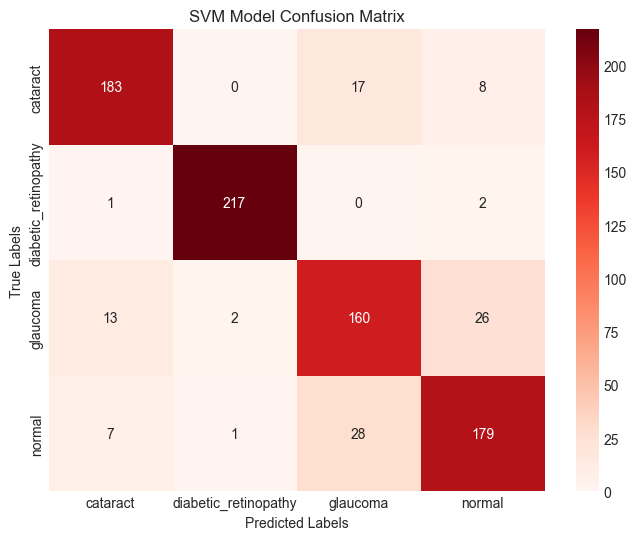

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Reds", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("SVM Model Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.linalg import pinv  # For calculating the pseudoinverse in ELM
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Step 1: Load the Pretrained Model and Set Up Feature Extraction
model = models.resnet50(pretrained=True)  # Use ResNet-50 model for feature extraction
model = nn.Sequential(*list(model.children())[:-1])  # Remove the final layer
model.eval()  # Set the model to evaluation mode

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Step 2: Set Up Dataset and DataLoader
data_dir = 'C:/Users/gudin/Downloads/eye disesases classification/dataset'  # Replace with the actual path to your dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input size
    transforms.ToTensor(),
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Step 3: Extract Features
feature_list = []
label_list = []

with torch.no_grad():  # Disable gradient calculations for efficiency
    for images, labels in tqdm.tqdm(data_loader):
        features = model(images)
        features = features.view(features.size(0), -1)  # Flatten features to a 2D array
        feature_list.append(features.cpu().numpy())
        label_list.append(labels.cpu().numpy())

# Convert lists to arrays
features = np.concatenate(feature_list, axis=0)
labels = np.concatenate(label_list, axis=0)

# Step 4: Prepare Labels for ELM (One-hot Encoding)
num_classes = len(np.unique(labels))
one_hot_labels = np.eye(num_classes)[labels]

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    features, one_hot_labels, test_size=0.2, random_state=42, stratify=labels
)

# Step 5: Define and Train an ELM Model
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        # Randomly initialize hidden layer weights
        self.input_weights = np.random.normal(size=[input_size, hidden_size])
        self.biases = np.random.normal(size=[hidden_size])
        # Output weights will be calculated analytically
        self.output_weights = None
        self.output_size = output_size

    def _activation(self, X):
        # Activation function, using sigmoid here
        return 1 / (1 + np.exp(-X))

    def train(self, X, y):
        # Compute hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Compute output weights using pseudoinverse
        self.output_weights = np.dot(pinv(H), y)

    def predict(self, X):
        # Compute hidden layer output
        H = self._activation(np.dot(X, self.input_weights) + self.biases)
        # Compute final output
        output = np.dot(H, self.output_weights)
        return np.argmax(output, axis=1)

# Initialize ELM model
input_size = X_train.shape[1]
hidden_size = 1000  # You can adjust the hidden layer size
output_size = num_classes
elm_model = ELM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Train ELM
elm_model.train(X_train, y_train)

# Step 6: Evaluate the ELM Model
y_pred_elm = elm_model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot back to class labels
print("\nELM Model Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_elm))

print("\nELM Model Classification Report:")
print(classification_report(y_test_labels, y_pred_elm, target_names=dataset.classes))


C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gudin\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 132/132 [04:47<00:00,  2.18s/it]



ELM Model Classification Report:
                      precision    recall  f1-score   support

            cataract       0.86      0.81      0.83       208
diabetic_retinopathy       0.93      0.89      0.91       220
            glaucoma       0.69      0.72      0.70       201
              normal       0.74      0.79      0.76       215

            accuracy                           0.80       844
           macro avg       0.80      0.80      0.80       844
        weighted avg       0.81      0.80      0.80       844



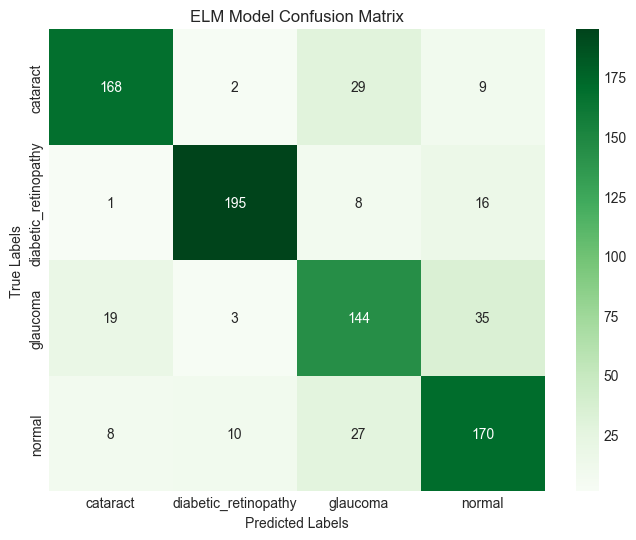

In [30]:
elm_cm = confusion_matrix(y_test_labels, y_pred_elm)
plt.figure(figsize=(8, 6))
sns.heatmap(elm_cm, annot=True, fmt="d", cmap="Greens", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("ELM Model Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()